# Microstate Extraction

In [5]:
import os
import mne
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1, 150)]
N_STATES = 4
SFREQ = 250  # adjust to your sampling frequency

def compute_microstate_features(labels, n_states=N_STATES, sfreq=SFREQ):
    features = {}
    total_samples = len(labels)
    changes = np.where(np.diff(labels) != 0)[0] + 1
    segment_starts = np.insert(changes, 0, 0)
    segment_lengths = np.diff(np.append(segment_starts, total_samples))
    segment_labels = labels[segment_starts]

    for s in range(n_states):
        state_segments = segment_lengths[segment_labels == s]
        features[f"MS{s+1}_coverage"] = np.sum(state_segments) / total_samples
        if len(state_segments) > 0:
            features[f"MS{s+1}_duration_ms"] = (state_segments.mean() / sfreq) * 1000
            features[f"MS{s+1}_occurrence_rate"] = len(state_segments) / (total_samples / sfreq)
        else:
            features[f"MS{s+1}_duration_ms"] = 0
            features[f"MS{s+1}_occurrence_rate"] = 0
    return features

def compute_transition_matrix(labels, n_states=N_STATES):
    T = np.zeros((n_states, n_states))
    for i in range(len(labels) - 1):
        T[labels[i], labels[i+1]] += 1
    # Normalize per row
    row_sums = T.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    return T / row_sums

for SUBJ in SUBJECTS:
    SUBJ_DIR = os.path.join(BASE_DIR, SUBJ)
    EPO_FILE = os.path.join(SUBJ_DIR, f"epo_{SUBJ[-3:]}_raw.fif")
    DATA_DIR = os.path.join(SUBJ_DIR, "data")
    os.makedirs(DATA_DIR, exist_ok=True)

    if not os.path.exists(EPO_FILE):
        print(f"{SUBJ}: epochs file missing, skipping")
        continue

    print(f"Processing {SUBJ}...")
    epochs = mne.read_epochs(EPO_FILE, preload=True)
    data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
    
    # Flatten epochs: concatenate epochs along time for clustering
    all_data = data.transpose(0, 2, 1).reshape(-1, data.shape[1])  # (n_epochs*n_times, n_channels)
    
    # Optional: normalize per channel
    all_data -= all_data.mean(axis=0)
    all_data /= all_data.std(axis=0) + 1e-12
    
    # K-means clustering
    kmeans = KMeans(n_clusters=N_STATES, random_state=42, n_init=10)
    labels = kmeans.fit_predict(all_data)
    
    # Compute microstate features
    features = compute_microstate_features(labels, n_states=N_STATES, sfreq=epochs.info["sfreq"])
    
    # Compute transition probabilities
    trans_matrix = compute_transition_matrix(labels, n_states=N_STATES)
    for i in range(N_STATES):
        for j in range(N_STATES):
            features[f"MS{i+1}_to_MS{j+1}_TP"] = trans_matrix[i, j]
    
    # Save features
    df = pd.DataFrame([features])
    out_file = os.path.join(DATA_DIR, f"{SUBJ}_microstate_features.csv")
    df.to_csv(out_file, index=False)
    print(f"Saved microstate features: {out_file}")


Processing sub-001...
Reading C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif ...
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated


C:\Users\User\AppData\Local\Temp\ipykernel_15172\406497669.py:51: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True)
c:\Users\User\anaconda3\envs\eeg_ml\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Saved microstate features: C:\Users\User\Documents\EEG_Project\rEEG\sub-001\data\sub-001_microstate_features.csv
Processing sub-002...
Reading C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif ...
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated


C:\Users\User\AppData\Local\Temp\ipykernel_15172\406497669.py:51: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True)


KeyboardInterrupt: 

## Narrowband Analysis

In [ ]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

# =========================
# CONFIG
# =========================
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1, 101)]
BANDS = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 13)}
N_MICROSTATES = 4
MIN_PEAK_MS = 10
MIN_LABEL_SAMPLES = 3

# =========================
# IMPROVED HELPERS
# =========================
def extract_gfp_maps(data, sfreq, min_peak_ms=10):
    # Vectorized GFP calculation
    gfp = np.std(data, axis=0) 
    min_samples = max(1, int((min_peak_ms / 1000) * sfreq))
    peaks, _ = find_peaks(gfp, distance=min_samples)
    
    maps = data[:, peaks].T
    # GFP normalization (in-place for memory efficiency)
    maps /= (gfp[peaks, None] + 1e-12)
    maps -= maps.mean(axis=1, keepdims=True)
    return maps

def compute_microstate_stats(labels, sfreq, n_states):
    total_samples = len(labels)
    # Fast segment identification using where/diff
    changes = np.where(np.diff(labels) != 0)[0] + 1
    starts = np.insert(changes, 0, 0)
    lengths = np.diff(np.append(starts, total_samples))
    states = labels[starts]

    stats = {}
    # Pre-compute transition matrix for speed
    T = np.zeros((n_states, n_states))
    for i in range(len(labels)-1):
        T[labels[i], labels[i+1]] += 1
    row_sums = T.sum(axis=1, keepdims=True)
    T /= np.maximum(row_sums, 1)

    for s in range(n_states):
        segs = lengths[states == s]
        stats[f"MS{s+1}_coverage"] = np.sum(segs) / total_samples
        stats[f"MS{s+1}_duration_ms"] = (segs.mean()/sfreq*1000) if len(segs) else 0
        stats[f"MS{s+1}_occurrence"] = (len(segs)/(total_samples/sfreq)) if len(segs) else 0
        for j in range(n_states):
            stats[f"T_{s+1}_{j+1}"] = T[s, j]
    return stats

# =========================================================
# OPTIMIZED EXECUTION: LOAD ONCE, PROCESS TWICE
# =========================================================
all_peak_maps = []
subject_cache = {} # Stores filtered data to avoid re-filtering in Step 3

print("Step 1: Extracting GFP Peaks...")
for SUBJ in SUBJECTS:
    EPO_FILE = os.path.join(BASE_DIR, SUBJ, f"epo_{SUBJ[-3:]}_raw.fif")
    if not os.path.exists(EPO_FILE): continue
    
    # Load once
    epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
    sfreq = epochs.info['sfreq']
    subject_cache[SUBJ] = {}

    for band, (fmin, fmax) in BANDS.items():
        # Filter once
        filt = epochs.copy().filter(fmin, fmax, fir_design='firwin', verbose=False).get_data()
        data = filt.transpose(1, 0, 2).reshape(epochs.info['nchan'], -1)
        
        # Cache filtered data for Step 3
        subject_cache[SUBJ][band] = data
        
        # Extract maps for Step 2
        all_peak_maps.append(extract_gfp_maps(data, sfreq, MIN_PEAK_MS))

# STEP 2: Clustering
print("Step 2: Clustering...")
km_global = KMeans(n_clusters=N_MICROSTATES, random_state=42, n_init=10)
global_templates = km_global.fit(np.vstack(all_peak_maps)).cluster_centers_
np.save(os.path.join(BASE_DIR, "microstate_templates.npy"), global_templates)

# STEP 3: Backfitting using Cache
print("Step 3: Backfitting and Stats...")
# Pre-normalize templates for faster dot product correlation
norm_templates = global_templates / (np.linalg.norm(global_templates, axis=1, keepdims=True) + 1e-12)

for SUBJ, bands_data in subject_cache.items():
    DATA_DIR = os.path.join(BASE_DIR, SUBJ, "data")
    os.makedirs(DATA_DIR, exist_ok=True)
    all_band_features = []

    for band_name, data in bands_data.items():
        # Optimized Backfitting (Spatial Correlation)
        data_zero = data - data.mean(axis=0, keepdims=True)
        data_norm = data_zero / (np.linalg.norm(data_zero, axis=0, keepdims=True) + 1e-12)
        
        # Correlation is now a simple dot product
        labels = np.argmax(np.abs(np.dot(norm_templates, data_norm)), axis=0)
        
        # Stats
        band_stats = compute_microstate_stats(labels, sfreq, N_MICROSTATES)
        band_stats.update({"band": band_name, "subject": SUBJ})
        all_band_features.append(band_stats)

    pd.DataFrame(all_band_features).to_csv(
        os.path.join(DATA_DIR, f"{SUBJ}_microstate_global.csv"), index=False
    )


Step 1: Extracting GFP Peaks...


C:\Users\User\AppData\Local\Temp\ipykernel_35588\3861357494.py:70: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_35588\3861357494.py:70: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_35588\3861357494.py:70: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep

Step 2: Clustering...
Step 3: Backfitting and Stats...


In [6]:
import os
import glob
import numpy as np
import pandas as pd

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
OUT_FILE = "microstate_temporal_instability.csv"

rows = []

for subj_dir in glob.glob(os.path.join(BASE_DIR, "sub-*")):
    subj = os.path.basename(subj_dir)
    files = glob.glob(os.path.join(subj_dir, "data", "*microstate_narrowband.csv"))

    for f in files:
        df = pd.read_csv(f)

        # one row per band per subject
        for _, row in df.iterrows():
            band = row["band"]

            # ---- collect per-class values ----
            durations = []
            occurrences = []
            coverages = []

            for k in range(1, 5):  # MS1–MS4
                durations.append(row.get(f"MS{k}_duration_ms", np.nan))
                occurrences.append(row.get(f"MS{k}_occurrence", np.nan))
                coverages.append(row.get(f"MS{k}_coverage", np.nan))

            durations = np.array(durations, dtype=float)
            occurrences = np.array(occurrences, dtype=float)
            coverages = np.array(coverages, dtype=float)

            # ---- instability metrics ----
            dur_var = np.nanvar(durations)
            occ_var = np.nanvar(occurrences)

            cov_mean = np.nanmean(coverages)
            cov_std = np.nanstd(coverages)
            cov_cv = cov_std / cov_mean if cov_mean > 0 else np.nan

            rows.append({
                "subject": subj,
                "band": band,
                
import os
import glob
import numpy as np
import pandas as pd

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
OUT_FILE = "microstate_temporal_instability.csv"

rows = []

for subj_dir in glob.glob(os.path.join(BASE_DIR, "sub-*")):
    subj = os.path.basename(subj_dir)
    files = glob.glob(os.path.join(subj_dir, "data", "*microstate_narrowband.csv"))

    for f in files:
        df = pd.read_csv(f)

        # one row per band per subject
        for _, row in df.iterrows():
            band = row["band"]

            # ---- collect per-class values ----
            durations = []
            occurrences = []
            coverages = []

            for k in range(1, 5):  # MS1–MS4
                durations.append(row.get(f"MS{k}_duration_ms", np.nan))
                occurrences.append(row.get(f"MS{k}_occurrence", np.nan))
                coverages.append(row.get(f"MS{k}_coverage", np.nan))

            durations = np.array(durations, dtype=float)
            occurrences = np.array(occurrences, dtype=float)
            coverages = np.array(coverages, dtype=float)

            # ---- instability metrics ----
            dur_var = np.nanvar(durations)
            occ_var = np.nanvar(occurrences)

            cov_mean = np.nanmean(coverages)
            cov_std = np.nanstd(coverages)
            cov_cv = cov_std / cov_mean if cov_mean > 0 else np.nan

            rows.append({
                "subject": subj,
                "band": band,
                "MS_duration_variance": dur_var,
                "MS_occurrence_variance": occ_var,
                "MS_coverage_CV": cov_cv
            })

# ---- save ----
out_df = pd.DataFrame(rows)
out_df.to_csv(OUT_FILE, index=False)

print(f"Saved temporal instability features → {OUT_FILE}")

                "MS_duration_variance": dur_var,
                "MS_occurrence_variance": occ_var,
                "MS_coverage_CV": cov_cv
            })

# ---- save ----
out_df = pd.DataFrame(rows)
out_df.to_csv(OUT_FILE, index=False)

print(f"Saved temporal instability features → {OUT_FILE}")


SyntaxError: invalid syntax (754807264.py, line 48)

## Statistical Testing for Microstate Instability

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, pearsonr, spearmanr

# =========================
# LOAD DATA
# =========================
FEATURE_FILE = "microstate_temporal_instability.csv"
META_FILE = "participants.csv"   # your MoCA CSV

feat = pd.read_csv(FEATURE_FILE)
meta = pd.read_csv(META_FILE)

# standardize column names
meta = meta.rename(columns={
    "participant_id": "subject",
    "MOCA": "MoCA"
})

# merge
df = feat.merge(meta[["subject", "MoCA"]], on="subject", how="inner")

# filter first 100 PD subjects
df = df[df["subject"].str.extract(r"sub-(\d+)").astype(int)[0] <= 100]

# define impairment
df["impaired"] = df["MoCA"] < 26

FEATURES = [
    "MS_duration_variance",
    "MS_occurrence_variance",
    "MS_coverage_CV"
]

BANDS = ["delta", "theta", 'alpha']

# =========================
# STATS
# =========================
for band in BANDS:
    print("\n" + "=" * 60)
    print(f"BAND: {band.upper()}")
    print("=" * 60)

    d = df[df["band"] == band]

    imp = d[d["impaired"]]
    unim = d[~d["impaired"]]

    print(f"N impaired = {len(imp)} | N unimpaired = {len(unim)}")

    for feat_name in FEATURES:
        x_imp = imp[feat_name].dropna()
        x_unim = unim[feat_name].dropna()

        # group difference
        t, p = ttest_ind(x_imp, x_unim, equal_var=False)

        # correlations
        r_p, p_p = pearsonr(d[feat_name], d["MoCA"])
        r_s, p_s = spearmanr(d[feat_name], d["MoCA"])

        print(f"\nFeature: {feat_name}")
        print(f"Impaired mean = {x_imp.mean():.4f}")
        print(f"Unimpaired mean = {x_unim.mean():.4f}")
        print(f"Group diff: t = {t:.3f}, p = {p:.4g}")
        print(f"Pearson r vs MoCA = {r_p:.3f}, p = {p_p:.4g}")
        print(f"Spearman r vs MoCA = {r_s:.3f}, p = {p_s:.4g}")



BAND: DELTA
N impaired = 53 | N unimpaired = 47

Feature: MS_duration_variance
Impaired mean = 112.5018
Unimpaired mean = 219.3072
Group diff: t = -1.375, p = 0.1747
Pearson r vs MoCA = 0.155, p = 0.1225
Spearman r vs MoCA = 0.056, p = 0.5772

Feature: MS_occurrence_variance
Impaired mean = 0.0721
Unimpaired mean = 0.1559
Group diff: t = -1.230, p = 0.2244
Pearson r vs MoCA = 0.138, p = 0.1699
Spearman r vs MoCA = 0.004, p = 0.9662

Feature: MS_coverage_CV
Impaired mean = 0.1699
Unimpaired mean = 0.1947
Group diff: t = -0.799, p = 0.427
Pearson r vs MoCA = 0.128, p = 0.2039
Spearman r vs MoCA = -0.013, p = 0.901

BAND: THETA
N impaired = 53 | N unimpaired = 47

Feature: MS_duration_variance
Impaired mean = 24.4821
Unimpaired mean = 764.2913
Group diff: t = -1.006, p = 0.3198
Pearson r vs MoCA = 0.094, p = 0.3534
Spearman r vs MoCA = 0.058, p = 0.5656

Feature: MS_occurrence_variance
Impaired mean = 1.5018
Unimpaired mean = 2.0571
Group diff: t = -0.641, p = 0.5234
Pearson r vs MoCA = 

In [7]:
import os
import glob
import pandas as pd
import numpy as np

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
OUT_FILE = "microstate_temporal_instability_with_interactions.csv"

rows = []

for subj_dir in glob.glob(os.path.join(BASE_DIR, "sub-*")):
    subj = os.path.basename(subj_dir)
    micro_files = glob.glob(os.path.join(subj_dir, "data", "*microstate_narrowband.csv"))
    power_file = os.path.join(subj_dir, "data", "frontal_delta_power.csv")  # adjust to your actual file
    plv_file = os.path.join(subj_dir, "data", "frontal_central_theta_plv.csv")  # adjust
    entropy_file = os.path.join(subj_dir, "data", "theta_entropy.csv")  # adjust

    if not micro_files:
        continue
    micro_df = pd.read_csv(micro_files[0])

    # load auxiliary metrics
    frontal_delta = pd.read_csv(power_file).set_index('subject') if os.path.exists(power_file) else None
    theta_plv = pd.read_csv(plv_file).set_index('subject') if os.path.exists(plv_file) else None
    theta_entropy = pd.read_csv(entropy_file).set_index('subject') if os.path.exists(entropy_file) else None

    for _, row in micro_df.iterrows():
        band = row["band"]
        out_row = row.to_dict()
        out_row["subject"] = subj

        # Interaction 1: Delta-band MS-A coverage × frontal delta power
        if band == "delta" and frontal_delta is not None:
            power_val = frontal_delta.loc[subj, "frontal_delta_power"]
            out_row["MSA_delta_cov_x_frontal_delta_power"] = row["MS1_coverage"] * power_val

        # Interaction 2: Theta-band MS-D occurrence × frontal–central PLV
        if band == "theta" and theta_plv is not None:
            plv_val = theta_plv.loc[subj, "theta_frontal_central_plv"]
            out_row["MSD_theta_occ_x_frontal_central_PLV"] = row["MS4_occurrence"] * plv_val

        # Interaction 3: MS-D → MS-A transition probability × theta-band entropy
        if theta_entropy is not None:
            ent_val = theta_entropy.loc[subj, "theta_entropy"]
            out_row["MSD_to_MSA_TP_x_theta_entropy"] = row.get("T_4_1", np.nan) * ent_val

        rows.append(out_row)

# Save new CSV with interactions
out_df = pd.DataFrame(rows)
out_df.to_csv(OUT_FILE, index=False)
print(f"Saved CSV with interaction features → {OUT_FILE}")


Saved CSV with interaction features → microstate_temporal_instability_with_interactions.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import mne
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

# =========================
# CONFIGURATION
# =========================
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1, 101)]
BANDS = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 13)}
N_STATES = 4  # Standard Classes A, B, C, D

# =========================
# FUNCTIONS
# =========================

def extract_gfp_peaks(data, sfreq):
    """Extracts topographic maps only at Global Field Power peaks."""
    gfp = np.std(data, axis=0)
    peaks, _ = find_peaks(gfp, distance=int(sfreq * 0.01)) # 10ms min distance
    maps = data[:, peaks].T
    # Normalize maps spatially (Standard Practice)
    maps -= maps.mean(axis=1, keepdims=True)
    maps /= maps.std(axis=1, keepdims=True) + 1e-12
    return maps

def backfit_and_stats(data, templates, sfreq):
    """Assigns data points to global templates and calculates metrics."""
    # Spatial correlation for backfitting
    data_norm = (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-12)
    corr = np.dot(templates, data_norm)
    labels = np.argmax(np.abs(corr), axis=0)
    
    # Calculate Coverage, Duration, Occurrence
    stats = {}
    total_time = len(labels)
    for s in range(N_STATES):
        state_mask = (labels == s)
        occurrence = np.diff(state_mask.astype(int)) == 1
        n_events = np.sum(occurrence)
        
        stats[f"MS_Class_{chr(65+s)}_coverage"] = np.mean(state_mask)
        stats[f"MS_Class_{chr(65+s)}_occurrence"] = n_events / (total_time / sfreq)
        if n_events > 0:
            stats[f"MS_Class_{chr(65+s)}_duration_ms"] = (np.sum(state_mask) / n_events / sfreq) * 1000
        else:
            stats[f"MS_Class_{chr(65+s)}_duration_ms"] = 0
            
    return stats

# =========================
# MAIN EXECUTION
# =========================

# STEP 1: Create Global Templates (Representative brain maps for the whole group)
print("Gathering GFP peaks for Global Templates...")
all_maps = []
for SUBJ in SUBJECTS[:20]: # Use first 20 subjects to build the template (saves memory)
    EPO_FILE = os.path.join(BASE_DIR, SUBJ, f"epo_{SUBJ[-3:]}_raw.fif")
    if os.path.exists(EPO_FILE):
        epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
        # Extract from Alpha band for clear topography
        data = epochs.copy().filter(8, 13).get_data(copy=False).transpose(1, 0, 2).reshape(len(epochs.ch_names), -1)
        all_maps.append(extract_gfp_peaks(data, epochs.info['sfreq']))

# Generate the 4 Classes (A, B, C, D)
km = KMeans(n_clusters=N_STATES, random_state=42, n_init=10).fit(np.vstack(all_maps))
global_templates = km.cluster_centers_

# # STEP 2: Backfit to every subject for every band
# print("Backfitting and calculating stats...")
# final_results = []
# for SUBJ in SUBJECTS:
#     EPO_FILE = os.path.join(BASE_DIR, SUBJ, f"epo_{SUBJ[-3:]}_raw.fif")
#     if not os.path.exists(EPO_FILE): continue
    
#     epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
#     for band_name, (fmin, fmax) in BANDS.items():
#         data = epochs.copy().filter(fmin, fmax, verbose=False).get_data(copy=False).transpose(1, 0, 2).reshape(len(epochs.ch_names), -1)
#         stats = backfit_and_stats(data, global_templates, epochs.info['sfreq'])
#         stats['subject'] = SUBJ
#         stats['band'] = band_name
#         final_results.append(stats)

# # Save to one master CSV for statistical analysis
# pd.DataFrame(final_results).to_csv("Microstate_Class_Results.csv", index=False)
# print("Done! Results saved to Microstate_Class_Results.csv")

Gathering GFP peaks for Global Templates...


C:\Users\User\AppData\Local\Temp\ipykernel_40936\3843600018.py:120: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40936\3843600018.py:120: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40936\3843600018.py:120: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
 

Computing Polarity-Invariant K-Means...
Visualizing Microstate Classes...


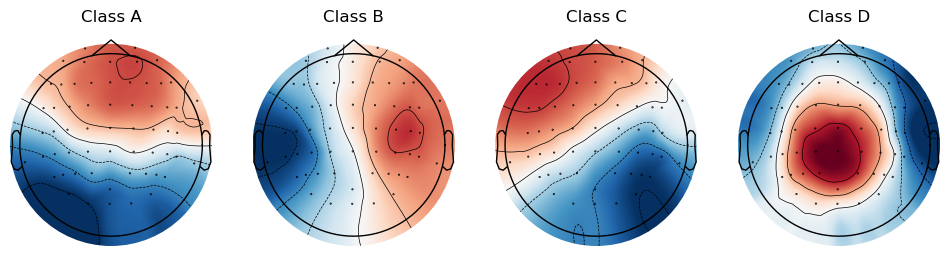

Backfitting all subjects and bands...


C:\Users\User\AppData\Local\Temp\ipykernel_40936\3843600018.py:150: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40936\3843600018.py:150: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40936\3843600018.py:150: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
 

Processing Complete. Results saved to Microstate_Analysis_Full_Results.csv


In [17]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import mode

# =========================
# CONFIGURATION
# =========================
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1, 101)]
BANDS = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 13)}
N_STATES = 4  # Standard Classes A, B, C, D

# =========================
# CORE FUNCTIONS
# =========================

def modified_kmeans(data, n_states, n_iter=100, random_state=42):
    """Modified K-Means for EEG: Invariant to map polarity."""
    rng = np.random.default_rng(random_state)
    # Initialize with random maps from the data
    templates = data[rng.choice(data.shape[0], n_states, replace=False)]
    
    for _ in range(n_iter):
        # 1. Assignment: Maximize absolute spatial correlation
        # corr shape: (n_states, n_timepoints)
        corr = np.dot(templates, data.T)
        labels = np.argmax(np.abs(corr), axis=0)
        
        # 2. Update: Average maps in each cluster, aligning polarity
        new_templates = np.zeros_like(templates)
        for s in range(n_states):
            idx = (labels == s)
            if not np.any(idx): continue
            
            cluster_maps = data[idx]
            # Align polarities to the first map in the cluster
            ref_map = cluster_maps[0]
            flips = np.sign(np.dot(cluster_maps, ref_map))
            cluster_maps_aligned = cluster_maps * flips[:, np.newaxis]
            
            new_templates[s] = np.mean(cluster_maps_aligned, axis=0)
            # Normalize map to unit length
            new_templates[s] /= (np.linalg.norm(new_templates[s]) + 1e-12)
            
        if np.allclose(templates, new_templates, atol=1e-6):
            break
        templates = new_templates
        
    return templates

def extract_gfp_peaks(data, sfreq):
    """Extracts topographic maps at Global Field Power peaks."""
    gfp = np.std(data, axis=0)
    peaks, _ = find_peaks(gfp, distance=int(sfreq * 0.01)) # 10ms min distance
    maps = data[:, peaks].T
    # Spatial Normalization
    maps -= maps.mean(axis=1, keepdims=True)
    maps /= (np.std(maps, axis=1, keepdims=True) + 1e-12)
    return maps

def backfit_and_stats(data, templates, sfreq):
    """Assigns data points to templates and calculates temporal & transition stats."""
    # Spatial correlation (polarity invariant)
    data_norm = (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-12)
    corr = np.dot(templates, data_norm)
    labels = np.argmax(np.abs(corr), axis=0)
    
    # Optional: Modal smoothing (3-sample window) to reduce noise
    for i in range(1, len(labels) - 1):
        if labels[i-1] == labels[i+1]:
            labels[i] = labels[i-1]

    stats = {}
    total_time = len(labels)
    
    # 1. Standard Metrics
    for s in range(N_STATES):
        state_mask = (labels == s)
        occurrence = np.diff(state_mask.astype(int), prepend=0) == 1
        n_events = np.sum(occurrence)
        
        class_label = chr(65 + s)
        stats[f"MS_{class_label}_coverage"] = np.mean(state_mask)
        stats[f"MS_{class_label}_occurrence"] = n_events / (total_time / sfreq)
        stats[f"MS_{class_label}_duration_ms"] = (np.sum(state_mask) / n_events / sfreq * 1000) if n_events > 0 else 0

    # 2. Transition Probabilities
    trans_matrix = np.zeros((N_STATES, N_STATES))
    for i in range(len(labels) - 1):
        if labels[i] != labels[i+1]:
            trans_matrix[labels[i], labels[i+1]] += 1
            
    row_sums = trans_matrix.sum(axis=1, keepdims=True)
    prob_matrix = np.divide(trans_matrix, row_sums, out=np.zeros_like(trans_matrix), where=row_sums!=0)
    
    for i in range(N_STATES):
        for j in range(N_STATES):
            if i == j: continue
            stats[f"Trans_{chr(65+i)}_to_{chr(65+j)}"] = prob_matrix[i, j]
            
    return stats

# =========================
# MAIN EXECUTION
# =========================

# STEP 1: Global Templates
print("Gathering GFP peaks for Global Templates...")
all_maps = []
sample_info = None

for SUBJ in SUBJECTS[:20]: # Subset for template building
    EPO_FILE = os.path.join(BASE_DIR, SUBJ, f"epo_{SUBJ[-3:]}_raw.fif")
    if not os.path.exists(EPO_FILE): continue
    
    epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
    sample_info = epochs.info
    
    # Filter for Alpha (standard for microstate template extraction)
    # Using copy(False) and transposing carefully to save RAM
    data = epochs.copy().filter(8, 13, verbose=False).get_data(copy=False)
    data = data.transpose(1, 0, 2).reshape(len(epochs.ch_names), -1)
    
    all_maps.append(extract_gfp_peaks(data, epochs.info['sfreq']))
    del epochs # Free memory

# Compute the templates
print("Computing Polarity-Invariant K-Means...")
global_templates = modified_kmeans(np.vstack(all_maps), N_STATES)

# Visualize Templates
print("Visualizing Microstate Classes...")
fig, axes = plt.subplots(1, N_STATES, figsize=(12, 3))
for i, (ax, temp) in enumerate(zip(axes, global_templates)):
    mne.viz.plot_topomap(temp, sample_info, axes=ax, show=False)
    ax.set_title(f"Class {chr(65+i)}")
plt.show()

# STEP 2: Subject-level Backfitting
print("Backfitting all subjects and bands...")
final_results = []
for SUBJ in SUBJECTS:
    EPO_FILE = os.path.join(BASE_DIR, SUBJ, f"epo_{SUBJ[-3:]}_raw.fif")
    if not os.path.exists(EPO_FILE): continue
    
    epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
    
    for band_name, (fmin, fmax) in BANDS.items():
        # Process band
        data_band = epochs.copy().filter(fmin, fmax, verbose=False).get_data(copy=False)
        data_band = data_band.transpose(1, 0, 2).reshape(len(epochs.ch_names), -1)
        
        # Calculate Stats
        stats = backfit_and_stats(data_band, global_templates, epochs.info['sfreq'])
        stats['subject'] = SUBJ
        stats['band'] = band_name
        final_results.append(stats)
        
    del epochs

# Save Final Results
df = pd.DataFrame(final_results)
df.to_csv("Microstate_Analysis_Full_Results.csv", index=False)
print("Processing Complete. Results saved to Microstate_Analysis_Full_Results.csv")

### Statistical Testing

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, spearmanr

# =========================
# CONFIG & LOADING
# =========================
RESULTS_FILE = "Microstate_Class_Results.csv"
META_FILE = "participants.csv"
MOCA_THRESHOLD = 26

df_micro = pd.read_csv(RESULTS_FILE)
df_meta = pd.read_csv(META_FILE)

# Merge microstate data with MoCA scores
df = df_micro.merge(df_meta[['participant_id', 'MOCA']], 
                    left_on='subject', right_on='participant_id')

df['impaired'] = df['MOCA'] < MOCA_THRESHOLD
bands = df['band'].unique()
classes = ['A', 'B', 'C', 'D']

# =========================
# ANALYSIS LOOP
# =========================
stat_results = []

for band in bands:
    print(f"\n--- Analyzing Band: {band.upper()} ---")
    df_band = df[df['band'] == band]
    
    for cls in classes:
        feature = f"MS_Class_{cls}_coverage"
        
        # Split groups
        group_imp = df_band[df_band['impaired']][feature].dropna()
        group_con = df_band[~df_band['impaired']][feature].dropna()
        
        # 1. T-Test (Group Difference)
        t_stat, p_val = ttest_ind(group_imp, group_con, equal_var=False)
        
        # 2. Spearman Correlation (MoCA Relationship)
        rho, p_corr = spearmanr(df_band[feature], df_band['MOCA'], nan_policy='omit')
        
        # Check if this matches the paper's prediction
        # (Paper says: Delta Class A increases, Delta Class D decreases)
        trend = "INCREASE" if group_imp.mean() > group_con.mean() else "DECREASE"
        
        print(f"Class {cls}: {trend} | p_diff={p_val:.4f} | rho={rho:.3f} (p={p_corr:.4f})")
        
        stat_results.append({
            'band': band,
            'class': cls,
            'p_value': p_val,
            'rho': rho,
            'p_corr': p_corr,
            'significant': p_val < 0.05
        })

# Save Summary
summary_df = pd.DataFrame(stat_results)
summary_df.to_csv("Microstate_Stats_Summary.csv", index=False)


--- Analyzing Band: DELTA ---
Class A: DECREASE | p_diff=0.3910 | rho=0.069 (p=0.4956)
Class B: INCREASE | p_diff=0.0720 | rho=-0.126 (p=0.2126)
Class C: INCREASE | p_diff=0.5117 | rho=-0.044 (p=0.6629)
Class D: DECREASE | p_diff=0.2247 | rho=0.084 (p=0.4062)

--- Analyzing Band: THETA ---
Class A: DECREASE | p_diff=0.4571 | rho=0.102 (p=0.3128)
Class B: INCREASE | p_diff=0.6874 | rho=-0.033 (p=0.7477)
Class C: INCREASE | p_diff=0.1645 | rho=-0.112 (p=0.2685)
Class D: DECREASE | p_diff=0.4192 | rho=-0.039 (p=0.6994)

--- Analyzing Band: ALPHA ---
Class A: DECREASE | p_diff=0.6017 | rho=0.097 (p=0.3385)
Class B: INCREASE | p_diff=0.4716 | rho=-0.097 (p=0.3374)
Class C: INCREASE | p_diff=0.4166 | rho=-0.046 (p=0.6480)
Class D: DECREASE | p_diff=0.3670 | rho=-0.039 (p=0.6999)


In [10]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.stats import ttest_ind, spearmanr

# =========================
# CONFIGURATION
# =========================
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
RESULTS_FILE = "Microstate_Class_Results.csv" # From your previous step
META_FILE = "participants.csv"

# Define the regions from the paper
REGIONS = {
    'frontal': ['Fz', 'F3', 'F4', 'Fp1', 'Fp2'],
    'central': ['Cz', 'C3', 'C4'],
    'occipital': ['Oz', 'O1', 'O2']
}

# The specific tests mentioned in the paper
TEST_CASES = [
    {'band': 'delta', 'class': 'A', 'region': 'frontal'},
    {'band': 'theta', 'class': 'D', 'region': 'central'},
    {'band': 'theta', 'class': 'B', 'region': 'occipital'}
]

# =========================
# PROCESSING
# =========================
sync_results = []
meta = pd.read_csv(META_FILE)

# Note: This assumes you have the 'global_templates' from the previous clustering script
for test in TEST_CASES:
    band = test['band']
    cls_idx = ord(test['class']) - 65 # A=0, B=1, etc.
    region_chs = REGIONS[test['region']]
    
    print(f"Testing {band} Class {test['class']} synchronization in {test['region']}...")

    for subj in meta['participant_id'].tolist():
        epo_path = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
        if not os.path.exists(epo_path): continue
        
        # 1. Load and filter data for the specific band
        epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
        freq_map = {'delta': (1, 4), 'theta': (4, 8)}
        fmin, fmax = freq_map[band]
        data = epochs.copy().filter(fmin, fmax, verbose=False).get_data(copy=False)
        
        # 2. Identify which samples belong to the target Microstate Class
        # (This uses the backfitting logic from your previous script)
        ch_names = [c.upper() for c in epochs.ch_names]
        region_idx = [ch_names.index(c.upper()) for c in region_chs if c.upper() in ch_names]
        
        # Flatten data for backfitting
        flat_data = data.transpose(1, 0, 2).reshape(len(ch_names), -1)
        
        # Simple backfit (Correlation with global templates)
        data_norm = (flat_data - flat_data.mean(axis=0)) / (flat_data.std(axis=0) + 1e-12)
        corr = np.dot(global_templates, data_norm)
        labels = np.argmax(np.abs(corr), axis=0)
        
        # 3. Calculate Synchronization (Regional GFP) during that class
        target_mask = (labels == cls_idx)
        if np.any(target_mask):
            # Regional GFP: Standard deviation across the selected electrodes
            regional_data = flat_data[region_idx, :][:, target_mask]
            sync_val = np.mean(np.std(regional_data, axis=0)) 
            
            sync_results.append({
                'subject': subj,
                'band': band,
                'class': test['class'],
                'region': test['region'],
                'sync_strength': sync_val,
                'MoCA': meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
            })

# =========================
# STATISTICAL ANALYSIS
# =========================
df_sync = pd.DataFrame(sync_results)
df_sync['impaired'] = df_sync['MoCA'] < 26

for test in TEST_CASES:
    sub_df = df_sync[(df_sync['band'] == test['band']) & (df_sync['region'] == test['region'])]
    
    imp = sub_df[sub_df['impaired']]['sync_strength']
    unimp = sub_df[~sub_df['impaired']]['sync_strength']
    
    t, p = ttest_ind(imp, unimp, equal_var=False)
    rho, p_corr = spearmanr(sub_df['sync_strength'], sub_df['MoCA'])
    
    print(f"\nRESULTS for {test['band'].upper()} Class {test['class']} ({test['region']}):")
    print(f"Group Diff: t={t:.3f}, p={p:.4f}")
    print(f"Correlation with MoCA: rho={rho:.3f}, p={p_corr:.4f}")
    df_sync.to_csv("Microstate_Sync_Features_All.csv", index=False)
    print("Saved Microstate_Sync_Features_All.csv")


C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-036\epo_036_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-037\epo_037_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-038\epo_038_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch

Testing theta Class D synchronization in central...


C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch

Testing theta Class B synchronization in occipital...


C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\922860838.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch


RESULTS for DELTA Class A (frontal):
Group Diff: t=1.767, p=0.0794
Correlation with MoCA: rho=-0.201, p=0.0137
Saved Microstate_Sync_Features_All.csv

RESULTS for THETA Class D (central):
Group Diff: t=3.207, p=0.0017
Correlation with MoCA: rho=-0.270, p=0.0009
Saved Microstate_Sync_Features_All.csv

RESULTS for THETA Class B (occipital):
Group Diff: t=0.946, p=0.3460
Correlation with MoCA: rho=-0.128, p=0.1204
Saved Microstate_Sync_Features_All.csv


In [18]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
META_FILE = "participants.csv"
OUT_FILE = "Microstate_Band_Sync_Features.csv"

REGIONS = {
    'frontal': ['Fz','F3','F4','Fp1','Fp2'],
    'central': ['Cz','C3','C4'],
    'occipital': ['Oz','O1','O2']
}

TEST_CASES = [
    {'band':'delta','class':'A','region':'frontal'},
    {'band':'theta','class':'D','region':'central'},
    {'band':'theta','class':'B','region':'occipital'}
]

FREQ_MAP = {'delta':(1,4),'theta':(4,8)}

meta = pd.read_csv(META_FILE)
results = []

for test in TEST_CASES:
    band = test['band']
    cls_idx = ord(test['class']) - 65
    region = test['region']
    fmin,fmax = FREQ_MAP[band]

    for subj in meta['participant_id']:
        epo = os.path.join(BASE_DIR,subj,f"epo_{subj[-3:]}_raw.fif")
        if not os.path.exists(epo): continue

        epochs = mne.read_epochs(epo,preload=True,verbose=False)
        ch_names = [c.upper() for c in epochs.ch_names]
        region_idx = [ch_names.index(c.upper()) for c in REGIONS[region] if c.upper() in ch_names]
        if len(region_idx)==0: continue

        # ---------- BROADBAND MICROSTATE BACKFITTING ----------
        broad = epochs.get_data(copy=False)
        flat_broad = broad.transpose(1,0,2).reshape(len(ch_names),-1)
        data_norm = (flat_broad-flat_broad.mean(axis=0))/(flat_broad.std(axis=0)+1e-12)
        corr = np.dot(global_templates,data_norm)
        labels = np.argmax(np.abs(corr),axis=0)

        # ---------- BANDPOWER EXTRACTION AFTER LABELING ----------
        band_data = epochs.copy().filter(fmin,fmax,verbose=False).get_data(copy=False)
        flat_band = band_data.transpose(1,0,2).reshape(len(ch_names),-1)
        target = flat_band[region_idx][:,labels==cls_idx]

        if target.shape[1]==0: continue
        sync = np.mean(np.std(target,axis=0))

        results.append({
            'subject':subj,
            'band':band,
            'class':test['class'],
            'region':region,
            'sync_strength':sync,
            'MoCA':meta.loc[meta['participant_id']==subj,'MOCA'].values[0]
        })

df = pd.DataFrame(results)
df.to_csv(OUT_FILE,index=False)
print(f"Saved {OUT_FILE}")

# ---------- STATS ----------
df['impaired'] = df['MoCA'] < 26

for test in TEST_CASES:
    sub = df[(df['band']==test['band'])&(df['region']==test['region'])]
    imp = sub[sub['impaired']]['sync_strength']
    unimp = sub[~sub['impaired']]['sync_strength']
    t,p = ttest_ind(imp,unimp,equal_var=False)
    rho,pc = spearmanr(sub['sync_strength'],sub['MoCA'])
    print(f"\n{test['band'].upper()} Class {test['class']} {test['region']}")
    print(f"t={t:.3f} p={p:.4f} | rho={rho:.3f} p={pc:.4f}")


C:\Users\User\AppData\Local\Temp\ipykernel_40936\1138910983.py:38: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-132\epo_132_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo,preload=True,verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40936\1138910983.py:38: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-133\epo_133_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo,preload=True,verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40936\1138910983.py:38: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-134\epo_134_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.rea

Saved Microstate_Band_Sync_Features.csv

DELTA Class A frontal
t=1.864 p=0.0644 | rho=-0.213 p=0.0090

THETA Class D central
t=3.240 p=0.0016 | rho=-0.265 p=0.0011

THETA Class B occipital
t=1.124 p=0.2628 | rho=-0.137 p=0.0958


In [11]:
import os
import numpy as np
import pandas as pd
import mne
from scipy.stats import ttest_ind
from scipy.integrate import simpson
from sklearn.cluster import KMeans
# =========================
# CONFIGURATION
# =========================
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
META_FILE = "participants.csv"
global_templates = km.cluster_centers_
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30)
}

# =========================
# SPECTRAL HELPERS
# =========================
def get_band_power(psd, freqs, band):
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return simpson(psd[idx], x=freqs[idx])

# =========================
# MAIN PROCESSING
# =========================
meta = pd.read_csv(META_FILE)
spectral_results = []

for subj in meta['participant_id']:
    epo_path = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_path):
        continue

    epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
    sfreq = epochs.info['sfreq']

    data = epochs.get_data(copy=False)
    data = data.transpose(1, 0, 2).reshape(len(epochs.ch_names), -1)

    # -------------------------
    # Microstate backfitting
    # -------------------------
    data_norm = (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-12)
    corr = np.dot(global_templates, data_norm)
    labels = np.argmax(np.abs(corr), axis=0)

    # -------------------------
    # Spectral analysis per state
    # -------------------------
    for s in range(4):  # A–D
        mask = labels == s
        if mask.sum() < sfreq:
            continue

        state_data = data[:, mask]

        psds, freqs = mne.time_frequency.psd_array_welch(
            state_data,
            sfreq=sfreq,
            fmin=1,
            fmax=40,
            verbose=False
        )

        avg_psd = psds.mean(axis=0)

        d_p = get_band_power(avg_psd, freqs, BANDS['delta'])
        t_p = get_band_power(avg_psd, freqs, BANDS['theta'])
        a_p = get_band_power(avg_psd, freqs, BANDS['alpha'])
        b_p = get_band_power(avg_psd, freqs, BANDS['beta'])

        spectral_results.append({
            'subject': subj,
            'class': chr(65 + s),
            'delta_power': d_p,
            'theta_power': t_p,
            'alpha_power': a_p,
            'beta_power': b_p,
            'theta_alpha_ratio': t_p / (a_p + 1e-12),
            'slow_fast_ratio': (d_p + t_p) / (a_p + b_p + 1e-12),
            'MoCA': meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
        })

# =========================
# STATS
# =========================
df_spec = pd.DataFrame(spectral_results)
df_spec['impaired'] = df_spec['MoCA'] < 26

for cls in ['A', 'D']:
    sub = df_spec[df_spec['class'] == cls]
    t, p = ttest_ind(
        sub[sub['impaired']]['theta_alpha_ratio'],
        sub[~sub['impaired']]['theta_alpha_ratio'],
        equal_var=False
    )
    print(f"MS-Class {cls} | Theta/Alpha Ratio | p = {p:.4g}")


C:\Users\User\AppData\Local\Temp\ipykernel_15172\773437115.py:39: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\773437115.py:39: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=True, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_15172\773437115.py:39: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoch

MS-Class A | Theta/Alpha Ratio | p = 0.1991
MS-Class D | Theta/Alpha Ratio | p = 0.1206
